In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# Train Data
df = pd.read_csv('data/train.csv')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


torch.Size([32, 1, 28, 28])
torch.Size([32])


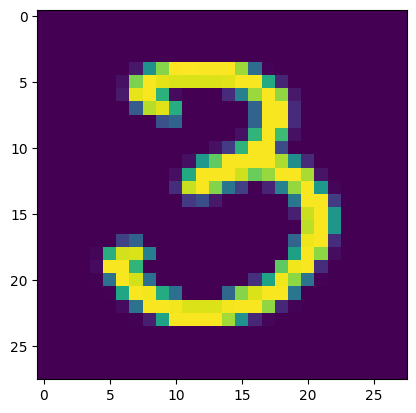

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, test=False):
        self.test = test
        if not self.test:
            self.y = dataframe['label']
            self.y = torch.tensor(self.y.values)
            self.X = dataframe.drop('label', axis=1)
        else:
            self.X = dataframe

        self.X = self.X.astype('float32') / 255.0 # normalize
        self.X = torch.tensor(self.X.values, dtype=torch.float32)
        self.X = self.X.reshape(-1, 1, 28, 28)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.test:
            return self.X[idx], -1
        else:
            return self.X[idx], self.y[idx]

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])
train_dataset = CustomDataset(train_df)
test_dataset  = CustomDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

# Test how it works :)
for X_train, y_train in train_loader:
    break
print(X_train.shape)
print(y_train.shape)
plt.imshow(X_train[0][0])

In [4]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        # in: 28x28
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),  # out: 32*26*26
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # out: 32*13*13
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  # out: 64*11*11
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # out: 64*5*5
            nn.Flatten(),
            nn.Linear(in_features=64*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self.layers(x)
        return F.log_softmax(x, dim=1)

model = AdvancedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

AdvancedCNN(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1600, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
best_accuracy = 0.0
best_model = None
best_epoch = -1

epochs = 30 # too big number on purpose, want to detect an overfit
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)
for i in range(epochs):
    # Train
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for X_train, y_train in tqdm(train_loader, desc=f'Epoch {i}/{epochs} (Training)'):
        X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
        optimizer.zero_grad()
        # Forward
        y_predicted = model(X_train)
        loss = criterion(y_predicted, y_train)
        _, predicted = torch.max(y_predicted, 1)
        total += y_train.size(0)
        correct += (predicted == y_train).sum()
        running_loss += loss
        # Update parameters
        loss.backward()
        optimizer.step()
    # Training accuracy
    train_accuracy.append(correct / total)
    # Average training loss
    avg_loss = running_loss / len(train_loader)
    train_loss.append(avg_loss)
    print(f'Epoch {i}/{epochs} (Training) Accuracy {correct / total} Loss {avg_loss}')
    weights = model.state_dict()
    torch.save(weights, f'weights/model_weights_epoch_{i}.pt')

    # Test
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for X_test, y_test in tqdm(test_loader, desc=f'Epoch {i}/{epochs} (Validation)'):
            X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
            y_validation = model(X_test)
            _, predicted = torch.max(y_validation, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum()
            # Compute testing loss
            loss = criterion(y_validation, y_test)
            running_loss += loss
    # Average testing loss
    avg_loss = running_loss / len(test_loader)
    test_loss.append(avg_loss)
    # Testing accuracy
    accuracy = correct / total
    test_accuracy.append(accuracy)
    print(f'Epoch {i}/{epochs} (Validation) Accuracy {accuracy} Loss {avg_loss}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model.state_dict()
        best_epoch = i

model.load_state_dict(best_model)
print(f'Best accuracy {best_accuracy} at epoch {best_epoch}')

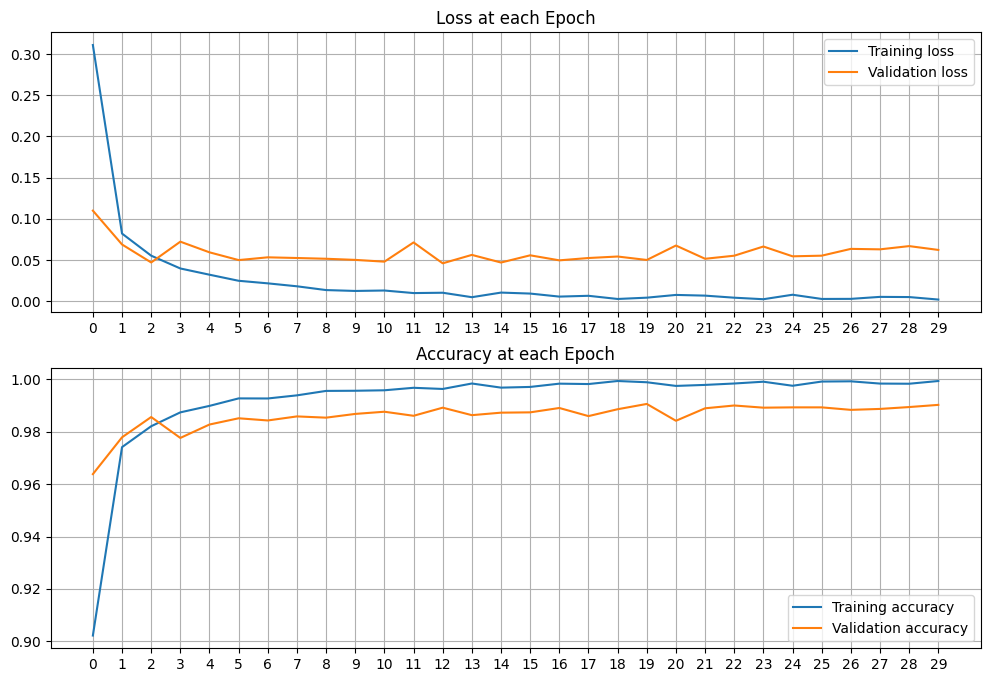

In [9]:
f, axarr = plt.subplots(2, 1, figsize=(12, 8))
axarr[0].plot([tl.item() for tl in train_loss], label='Training loss')
axarr[0].plot([tl.item() for tl in test_loss], label='Validation loss')
axarr[0].set_title('Loss at each Epoch')
axarr[0].set_xticks(range(len(train_loss)))
axarr[0].grid()
axarr[0].legend()
axarr[1].plot(train_accuracy, label='Training accuracy')
axarr[1].plot(test_accuracy,  label='Validation accuracy')
axarr[1].set_title('Accuracy at each Epoch')
axarr[1].set_xticks(range(len(test_loss)))
axarr[1].grid()
axarr[1].legend()

# v1 (good split): Best accuracy 0.9867857098579407 at epoch 14
# v2 (bigger conv): Best accuracy 0.9905952215194702 at epoch 19

In [21]:
# Submission Data
test_df = pd.read_csv('data/test.csv')
test_dataset = CustomDataset(test_df, test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
predicted_labels = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().tolist())

output_data = pd.DataFrame({'Label': predicted_labels})
output_data.index += 1
output_data.index.names = ['ImageId']
output_data.to_csv('submission.csv')
output_data

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3
...,...
27996,9
27997,7
27998,3


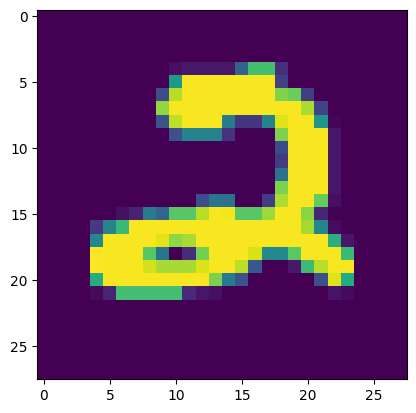

In [26]:
# Looks correct
img, _ = test_dataset[0]
plt.imshow(img[0])